In [ ]:
# # Install Libraries
# !pip install textblob
# !pip install tweepy
# !pip install pycountry
# !pip install wordcloud
# !pip install langdetect

### Business Problem:

* Stakeholder - Hedgefund
* Sentiment Analysis with NLP - Identify sentiment through tweets for dogecoin (negative, neutral, positive)
* check if twitter sentiment has any correlation for dogecoin price

* *Our model is the first academic proof of concept that social media platforms such as Twitter can serve as powerful social signals for predicting price movements in the highly speculative alternative cryptocurrency, or “alt-coin,” market.* [crypto_paper](https://www.frontiersin.org/articles/10.3389/fphy.2019.00098/full)


### Dataset:

* Twitter API searching for dogecoin (2500 tweets total)

### Methods:

* Base Model: Sentiment Intensity Analyzer on tweets without preprocessing

* Simple Model: Sentiment Intensity Analyzer on tweets with preprocessing
    - preprocessing: remove punctuation, lowercase, remove





In [ ]:
# Import Libraries
from textblob import TextBlob
import sys
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import nltk
import pycountry
import re
import string
import json

# from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score

In [ ]:
# nltk.download('vader_lexicon')

In [41]:
with open('/Users/evanjays/.secrets/twitter_creds.json') as f:
    creds = json.load(f)

df_2013 = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding = "ISO-8859-1")
df_2013.drop(6,inplace=True)

df = pd.read_csv('data/doge_tweets.csv',index_col=0)
df.columns = ['text']

In [42]:
df.head()

,text
0,RT @VikingFl0ki: @ProTheDoge 💣VIKING FLOKI PRE...
1,"RT @Doge_BUSD: 🚀📈💎Giveaway💎📈🚀\n\nRT, Follow us..."
2,RT @dream9kk: Elon Musk Thinks Dogecoin Is Sup...
3,"RT @MilgateTyler: ""Her hair, long, black and f..."
4,RT @VikingFl0ki: @ProTheDoge 💣VIKING FLOKI PRE...


# Apple Dataset Accuracy

In [ ]:
#Cleaning Text (RT, Punctuation etc)
#Creating new dataframe and new features
#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",x)
rt = lambda x: re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+://\S+)"," ",x)
df_2013["clean_text"] = df_2013.tweet_text.map(remove_rt).map(rt)
df_2013["clean_text"] = df_2013.clean_text.str.lower()
df_2013.head(10)

In [ ]:
df_2013[['polarity', 'subjectivity']] = df_2013['clean_text'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in df_2013['clean_text'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if neg > pos:
        df_2013.loc[index, 'sentiment'] = "negative"
    elif pos > neg:
        df_2013.loc[index, 'sentiment'] = "positive"
    else:
        df_2013.loc[index, 'sentiment'] = "neutral"
    df_2013.loc[index, 'neg'] = neg
    df_2013.loc[index, 'neu'] = neu
    df_2013.loc[index, 'pos'] = pos
    df_2013.loc[index, 'compound'] = comp
df_2013.head(10)

In [ ]:
df_2013.is_there_an_emotion_directed_at_a_brand_or_product.value_counts() / 9098 * 100

In [ ]:
def sent_to_num(x):
    if x == "Negative emotion":
        return 0
    elif x == "Positive emotion":
        return 1
    elif x == "No emotion toward brand or product":
        return 2
    elif x == "negative":
        return 0
    elif x == "positive":
        return 1
    elif x == "neutral":
        return 2
    elif x == "I can't tell":
        return np.nan

df_2013['true_sent'].dropna(axis=0,inplace=True)

df_2013['true_sent'] = df_2013['is_there_an_emotion_directed_at_a_brand_or_product'].map(sent_to_num)
df_2013['pred_sent'] = df_2013['sentiment'].map(sent_to_num)

df_pred = df_2013.filter(['true_sent','pred_sent']).copy(deep=True)
df_pred.dropna(inplace=True)
accuracy_score(df_pred['true_sent'],df_pred['pred_sent'])

In [ ]:
df_2013.head().iloc[3].tweet_text

# DOGECOIN DATASET

In [ ]:
# Authentication
consumerKey = creds['API Key']
consumerSecret = creds['API Key Secret']
accessToken = creds['Access Token']
accessTokenSecret = creds['Access Token Secret']
auth = tweepy.OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(accessToken, accessTokenSecret)
api = tweepy.API(auth)

In [89]:
#Sentiment Analysis
def percentage(part,whole):
 return 100 * float(part)/float(whole)
keyword = input('Please enter keyword or hastag to search: ')
noOfTweet = int(input ('Please enter how many tweets to analyze: '))
tweets = tweepy.Cursor(api.search_tweets, q=keyword+' -filter:retweets').items(noOfTweet)
positive = 0
negative = 0
neutral = 0
polarity = 0
tweet_list = []
tweet_date_list = []
neutral_list = []
negative_list = []
positive_list = []
for tweet in tweets:
 
 #print(tweet.text)
    tweet_list.append(tweet.text)
    tweet_date_list.append(tweet.created_at)
    analysis = TextBlob(tweet.text)
    score = SentimentIntensityAnalyzer().polarity_scores(tweet.text)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    polarity += analysis.sentiment.polarity

    if neg > pos:
        negative_list.append(tweet.text)
        negative += 1
    elif pos > neg:
        positive_list.append(tweet.text)
        positive += 1
    elif pos == neg:
        neutral_list.append(tweet.text)
        neutral += 1

positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.1f')
negative = format(negative, '.1f')
neutral = format(neutral, '.1f')

TooManyRequests: 429 Too Many Requests
88 - Rate limit exceeded

In [ ]:
#Number of Tweets (Total, Positive, Negative, Neutral)
tweet_list = pd.DataFrame(tweet_list)
neutral_list = pd.DataFrame(neutral_list)
negative_list = pd.DataFrame(negative_list)
positive_list = pd.DataFrame(positive_list)
print('total number: ',len(tweet_list))
print('positive number: ',len(positive_list))
print('negative number: ', len(negative_list))
print('neutral number: ',len(neutral_list))

In [ ]:
#Creating PieCart
labels = ['Positive ['+str(positive)+'%]' , 'Neutral ['+str(neutral)+'%]','Negative ['+str(negative)+'%]']
sizes = [positive, neutral, negative]
colors = ['yellowgreen', 'blue','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title("Sentiment Analysis Result for keyword= "+keyword+"" )
plt.axis('equal')
plt.show()

In [ ]:
tweet_list

In [ ]:
tweet_list.drop_duplicates(inplace = True)

In [ ]:
#Cleaning Text (RT, Punctuation etc)
#Creating new dataframe and new features
tw_list = pd.DataFrame(tweet_list)
tw_list["text"] = tw_list[0]
#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",x)
rt = lambda x: re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+://\S+)"," ",x)
tw_list["text"] = tw_list.text.map(remove_rt).map(rt)
tw_list["text"] = tw_list.text.str.lower()
tw_list.head(10)

In [ ]:
#Calculating Negative, Positive, Neutral and Compound values
tw_list[['polarity', 'subjectivity']] = tw_list['text'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in tw_list['text'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if neg > pos:
        tw_list.loc[index, 'sentiment'] = "negative"
    elif pos > neg:
        tw_list.loc[index, 'sentiment'] = "positive"
    else:
        tw_list.loc[index, 'sentiment'] = "neutral"
    tw_list.loc[index, 'neg'] = neg
    tw_list.loc[index, 'neu'] = neu
    tw_list.loc[index, 'pos'] = pos
    tw_list.loc[index, 'compound'] = comp
tw_list.head(10)

In [ ]:
#Creating new data frames for all sentiments (positive, negative and neutral)
tw_list_negative = tw_list[tw_list["sentiment"]=="negative"]
tw_list_positive = tw_list[tw_list["sentiment"]=="positive"]
tw_list_neutral = tw_list[tw_list["sentiment"]=="neutral"]

In [ ]:
def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
count_values_in_column(tw_list,"sentiment")

In [ ]:
# create data for Pie Chart
pc = count_values_in_column(tw_list,"sentiment")
names= pc.index
size=pc["Percentage"]
 
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['green','blue','red'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [ ]:
#Function to Create Wordcloud
def create_wordcloud(text):
    mask = np.array(Image.open("cloud.png"))
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color="white",
    mask = mask,
    max_words=3000,
    stopwords=stopwords,
    repeat=True)
    wc.generate(str(text))
    wc.to_file("wc.png")
    print("Word Cloud Saved Successfully")
    path="wc.png"
    display(Image.open(path))

In [ ]:
# #Creating wordcloud for all tweets
# create_wordcloud(tw_list["text"].values)

In [ ]:
# #Creating wordcloud for positive sentiment
# create_wordcloud(tw_list_positive["text"].values)

In [ ]:
# #Creating wordcloud for negative sentiment
# create_wordcloud(tw_list_negative["text"].values)

In [ ]:
#Calculating tweet's length and word count
tw_list['text_len'] = tw_list['text'].astype(str).apply(len)
tw_list['text_word_count'] = tw_list['text'].apply(lambda x: len(str(x).split()))
round(pd.DataFrame(tw_list.groupby("sentiment").text_len.mean()),2)

In [ ]:
round(pd.DataFrame(tw_list.groupby("sentiment").text_word_count.mean()),2)

In [ ]:
#Removing Punctuation
def remove_punct(text):
    text = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0–9]+', '', text)
    return text
tw_list['punct'] = tw_list['text'].apply(lambda x: remove_punct(x))
#Appliyng tokenization
def tokenization(text):
    text = re.split('\W+', text)
    return text
tw_list['tokenized'] = tw_list['punct'].apply(lambda x: tokenization(x.lower()))
#Removing stopwords
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    
tw_list['nonstop'] = tw_list['tokenized'].apply(lambda x: remove_stopwords(x))
#Applying Stemmer
ps = nltk.PorterStemmer()
def stemming(text):
    text = [ps.stem(word) for word in text]
    return text
tw_list['stemmed'] = tw_list['nonstop'].apply(lambda x: stemming(x))
#Cleaning Text
def clean_text(text):
    text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove punctuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    tokens = re.split('\W+', text_rc)    # tokenization
    text = [ps.stem(word) for word in tokens if word not in stopword]  # remove stopwords and stemming
    return text
tw_list.head()

In [ ]:
#Appliyng Countvectorizer
countVectorizer = CountVectorizer(analyzer=clean_text) 
countVector = countVectorizer.fit_transform(tw_list['text'])
print('{} Number of reviews has {} words'.format(countVector.shape[0], countVector.shape[1]))
# print(countVectorizer.get_feature_names())
# 1281 Number of reviews has 2966 words
count_vect_df = pd.DataFrame(countVector.toarray(), columns=countVectorizer.get_feature_names())
count_vect_df.head()

In [ ]:
# Most Used Words
count = pd.DataFrame(count_vect_df.sum())
countdf = count.sort_values(0,ascending=False).head(20)
countdf[1:11]

In [49]:
#Function to ngram
def get_top_n_gram(corpus,ngram_range,n=None):
    vec = CountVectorizer(ngram_range=ngram_range,stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n], bag_of_words
#n2_bigram
# n2_bigrams = get_top_n_gram(tw_list['text'],(2,2),20)
# n2_bigrams

In [ ]:
#n3_trigram
n3_trigrams = get_top_n_gram(tw_list['text'],(3,3),20)
n3_trigrams

## MODEL BUILDER

In [43]:
#Removing Punctuation
def remove_punct(text):
    text = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0–9]+', '', text)
    return text
df['punct'] = df['text'].apply(lambda x: remove_punct(x))
#Appliyng tokenization
def tokenization(text):
    text = re.split('\W+', text)
    return text
df['tokenized'] = df['punct'].apply(lambda x: tokenization(x.lower()))
#Removing stopwords
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    
df['nonstop'] = df['tokenized'].apply(lambda x: remove_stopwords(x))
#Applying Stemmer
ps = nltk.PorterStemmer()
def stemming(text):
    text = [ps.stem(word) for word in text]
    return text
df['stemmed'] = df['nonstop'].apply(lambda x: stemming(x))
#Cleaning Text
def clean_text(text):
    text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove punctuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    tokens = re.split('\W+', text_rc)    # tokenization
    text = [ps.stem(word) for word in tokens if word not in stopword]  # remove stopwords and stemming
    return text
df.head()

,text,punct,tokenized,nonstop,stemmed
0,RT @VikingFl0ki: @ProTheDoge 💣VIKING FLOKI PRE...,RT VikingFlki ProTheDoge 💣VIKING FLOKI PRESALE...,"[rt, vikingflki, prothedoge, viking, floki, pr...","[rt, vikingflki, prothedoge, viking, floki, pr...","[rt, vikingflki, prothedog, vike, floki, presa..."
1,"RT @Doge_BUSD: 🚀📈💎Giveaway💎📈🚀\n\nRT, Follow us...",RT DogeBUSD 🚀📈💎Giveaway💎📈🚀\n\nRT Follow us and...,"[rt, dogebusd, giveaway, rt, follow, us, and, ...","[rt, dogebusd, giveaway, rt, follow, us, tag, ...","[rt, dogebusd, giveaway, rt, follow, us, tag, ..."
2,RT @dream9kk: Elon Musk Thinks Dogecoin Is Sup...,RT dreamkk Elon Musk Thinks Dogecoin Is Superi...,"[rt, dreamkk, elon, musk, thinks, dogecoin, is...","[rt, dreamkk, elon, musk, thinks, dogecoin, su...","[rt, dreamkk, elon, musk, think, dogecoin, sup..."
3,"RT @MilgateTyler: ""Her hair, long, black and f...",RT MilgateTyler Her hair long black and flowin...,"[rt, milgatetyler, her, hair, long, black, and...","[rt, milgatetyler, hair, long, black, flowing,...","[rt, milgatetyl, hair, long, black, flow, grea..."
4,RT @VikingFl0ki: @ProTheDoge 💣VIKING FLOKI PRE...,RT VikingFlki ProTheDoge 💣VIKING FLOKI PRESALE...,"[rt, vikingflki, prothedoge, viking, floki, pr...","[rt, vikingflki, prothedoge, viking, floki, pr...","[rt, vikingflki, prothedog, vike, floki, presa..."


In [69]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [64]:
vec.shape

(2500, 14999)

In [71]:
top_list,vec = get_top_n_gram(df['text'], (1,3),500)

kmeans = KMeans(n_clusters=3)

pca = PCA(n_components=2)

pca_vec = pca.fit_transform(vec.todense())

kmeans.fit(pca_vec)

y_preds = kmeans.predict(pca_vec)

df_fin = df.copy(deep=True)

df_fin['predictions'] = y_preds

df_fin.value_counts('predictions')

print(silhouette_score(vec,y_preds))




0.2105006958651209

In [73]:
pca_vec.shape

(2500, 2)

In [75]:
y_preds.shape

(2500,)

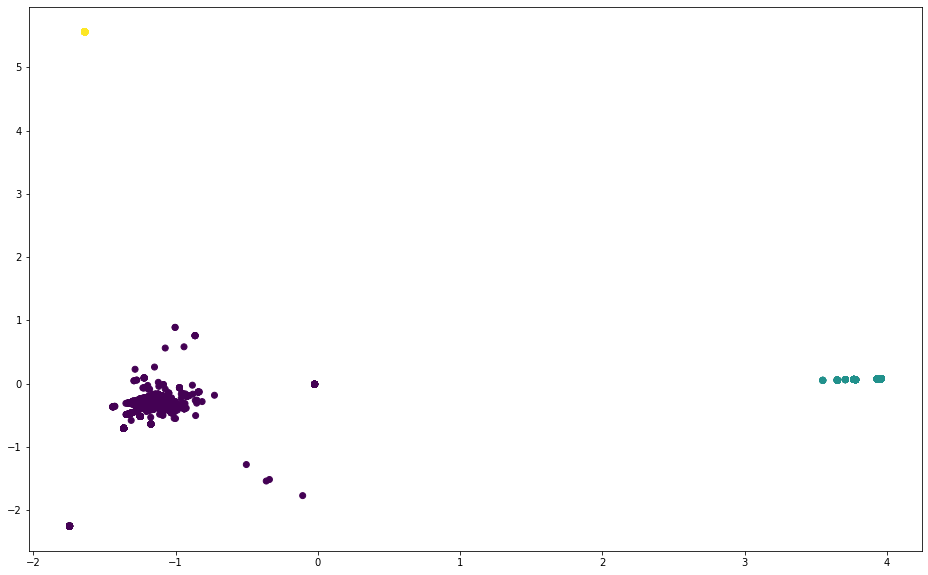

In [77]:
fig,ax = plt.subplots(figsize=(16,10))

ax.scatter(x=pca_vec[:,0],y=pca_vec[:,1],c=y_preds)

In [79]:
df_fin['predictions'].value_counts()

0    1779
1     585
2     136
Name: predictions, dtype: int64

In [87]:
df_fin[df_fin.predictions == 2].head(50)['text']

376     RT @FlokiDoge_: What an amazing launch! almost...
382     RT @FlokiDoge_: What an amazing launch! almost...
386     RT @FlokiDoge_: What an amazing launch! almost...
400     RT @FlokiDoge_: What an amazing launch! almost...
401     RT @FlokiDoge_: What an amazing launch! almost...
422     RT @FlokiDoge_: What an amazing launch! almost...
427     RT @FlokiDoge_: What an amazing launch! almost...
439     RT @FlokiDoge_: What an amazing launch! almost...
444     RT @FlokiDoge_: What an amazing launch! almost...
447     RT @FlokiDoge_: What an amazing launch! almost...
448     RT @FlokiDoge_: What an amazing launch! almost...
457     RT @FlokiDoge_: What an amazing launch! almost...
463     RT @FlokiDoge_: What an amazing launch! almost...
474     RT @FlokiDoge_: What an amazing launch! almost...
505     RT @FlokiDoge_: What an amazing launch! almost...
511     RT @FlokiDoge_: What an amazing launch! almost...
543     RT @FlokiDoge_: What an amazing launch! almost...
580     RT @Fl